<a href="https://colab.research.google.com/github/JuneY-Y/ML/blob/main/COMP9418_W08_Gaussian_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/UNSW-COMP9418/Week08/blob/main/COMP9418_W08_Gaussian_Factors_Solutions.ipynb)

# Gaussian Factors

**COMP9418 W08 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney
- Notebook designed by Gustavo Batista and Jeremy Gillen
- Last Update 14th July 2024
$\newcommand{\indep}{\perp \!\!\!\perp}\newcommand{\b}{\boldsymbol}$

# Technical Prerequisites

We will import the following modules for later use:

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt

# Introduction

This tutorial introduces Bayesian Networks that use continuous Gaussian instead of discrete random variables.

We start by implementing a new factor class. Our previous library, `DiscreteFactors`, uses tables to represent a probability distribution, which is inappropriate for continuous variables. Therefore, we will need a new representation of probability distribution to incorporate continuous variables into our models.

Unlike a table that can represent any discrete probability distribution, a continuous distribution will require a specific representation. This tutorial follows the lecture content and implements a factor for the ubiquitous Gaussian distribution.

This tutorial involves a large quantity of technical material summarised in Lecture 13. This lecture is based on the following content from the textbook *Probabilistic Graphical Models: Principles and Techniques*, by Koller & Friedman:

1. Continuous variables, Section 5.5, pg. 185-190.
2. Gaussian Network, Sections 7.1 & 7.2, pgs. 247-254.
3. Variable Elimination in Gaussian Networks Sections 14.1 & 14.2, pgs. 605-612..

## Gaussian distribution

An $n$-dimensional Gaussian distribution is defined with it's mean vector $\b\mu$ and covariance matrix $\Sigma$:
$$ P(\b x) = \frac{1}{(2\pi)^{n/2} |\Sigma|^{1/2}}\exp \left(-\frac{1}{2} (\b x - \b \mu)^T\Sigma^{-1}(\b x - \b \mu)\right). $$

Note that $|\Sigma|$ is the determinant of the covariance matrix.

This figure illustrates a bivariate Gaussian distribution. The centre of this distribution is given by the vector $\b\mu$.

![Bi-dimensional Gaussian](https://raw.githubusercontent.com/UNSW-COMP9418/Week08/main/img/Gaussian.png "Gaussian distribution")

Another relevant parameter is the covariance matrix that defines the dependencies between the Gaussian dimensions. When the dimensions are independent, the Gaussian has a round shape. Stronger dependencies will force the Gaussian to have a more elliptical shape.

![Contour plot of bi-dimensional Gaussians](https://raw.githubusercontent.com/UNSW-COMP9418/Week08/main/img/Covariance.png "Gaussians with different covariance matrices")

# Canonical representation for Gaussian distributions

A multidimensional Gaussian distribution can also be represented with the following equation:

$$ P(\b x) = \exp \left(-\frac{1}{2} \b{x}^T K \b x + \b h^T \b x + g\right),$$

where
* $\b x$ is an $n$-dimension vector representing the outcome of each variable
* $K = \Sigma^{-1}$ is an $n \times n$ matrix
* $\b h = \Sigma^{-1}\b \mu$ is an $n$-dimension vector
* $g = -\frac{1}{2}\b \mu^T\Sigma^{-1}\b \mu - \log\left((2\pi)^{n/2} |\Sigma|^{1/2}\right)$ is a scalar

This representation is relevant because we can easily implement the joint (multiplication), marginalisation (sum), and setting evidence using this representation. We use the notation $\mathcal{C}(K, \b h, g)$ to denote this representation. To represent a Gaussian distribution in the canonical form, we need to compute $K$, $\b h$, and $g$ from the mean and covariance matrix.

## Exercise

Let's start creating a new class, `GaussianFactor`. The idea is that this class will have a lot of flexibility in how we initiate it. We can initiate the class in the following ways:

1. As a Gaussian distribution with parameters $\b \mu$ and $\Sigma$.
2. As a Gaussian in canonical form with parameters $K$, $\b h$ and $g$.
3. As a conditional Gaussian distribution (we will discuss this part later).

Let's create the first method, `__init__`, which will give us multiple ways to initialize the distribution, as described above. The idea is that, regardless of how the class is initialised, it will internally store a canonical representation of the distribution.

In [3]:
class GaussianFactor:
    def __init__(self, domain, mu=None, sigma=None, parents=None, beta=None, b_mean=None, b_var=None, K=None, h=None, g=None):
        '''
        There are three ways to initialize this object.
        1. As a multivariate Gaussian
        domain:   A list or tuple of the names of each variable.
        mu:       The mean vector
        sigma:    The covariance matrix

        2. Directly with the canonical form of the parameters
        domain:  A list or tuple of the names of each variable.
        K:       see cell above (or Koller&Friedman textbook (section 14.2.1.1)) for definitions of these variables
        h:
        g:

        3. As a conditional distribution Y|X where Y = beta^T X + b
        domain:   List of names with the *child variable first*.
        beta:     The vector of parameters that define the scale of each of the variables X_i
        b_mean:   The mean of b
        b_var:    The variance of b
        '''
        n = len(domain)
        self.domain = domain
        if mu is not None and sigma is not None:
            mu, sigma = np.array(mu).reshape((n,)), np.array(sigma).reshape((n,n))
            self.K = np.linalg.inv(sigma) # TODO
            self.h = self.K@mu # TODO
            self.g = -(1/2)*mu.T@self.K@mu - np.log(((2*np.pi)**(n/2))*np.linalg.det(sigma)**(1/2))# TODO
        elif K is not None and h is not None and g is not None:
            self.K = np.array(K).reshape((n,n))
            self.h = np.array(h).reshape((n,))
            self.g = g
        elif beta is not None and b_mean is not None and b_var is not None:
            # We will complete the function below in the next exercise
            K,h,g = self._init_as_conditional(domain[0],domain[1:], beta, b_mean, b_var)
            self.K = K
            self.h = h
            self.g = g
        else:
            raise ValueError("Insufficient arguments")

## Testing class initialisation

Let's now extend the `GaussianFactor` class with some useful methods:

1. Calculate the density of a point.
2. Plot the Gaussian (1 dimension) or contour diagram (2 dimensions).
3. Return the mean.
4. Return the covariance matrix.
5. Copy the class object, returning a deep copy of the object.
6. Returning a textual representation of the class used with the `print` function (helpful for debugging purposes).

All these methods are implemented below. There is no need for you to modify or add code.

In [4]:
class GaussianFactor(GaussianFactor):

    def density(self, x):
        '''
        x:  ndarray of shape [..., len(domain)], to specify the set of
        points in the domain space for which the density should be returned.

        returns: ndarray of shape [...], same as input but missing final dimension.
        '''
        x = np.array(x)
        if x.shape == tuple():
            x = x.reshape(-1)
        if len(self.domain) == 1 and x.shape[-1] != 1:
            x = x.reshape((*x.shape,1))
        assert(x.shape[-1] == len(self.domain))
        output_shape = x.shape[:-1]
        xT = np.array(x).reshape((*x.shape[:-1],1,len(self.domain)))
        x = np.array(x).reshape((*x.shape[:-1],len(self.domain),1))
        hT = self.h.reshape(1,len(self.domain))
        return np.exp(-(1/2)*xT@self.K@x+hT@x+self.g).reshape(output_shape)

    def plot(self):
        '''
        If mean() and covariance() are well defined (and sometimes when they aren't),
        this function will plot a graph or contour diagram of the distribution.
        Limited to 1 or 2-dimensional factors.
        '''
        try:
            mu = self.mean()
        except np.linalg.LinAlgError:
            raise np.linalg.LinAlgError("Can't plot conditional distributions")

        if len(self.domain) == 1:
            mu = self.mean()
            sigma = np.sqrt(self.covariance())[0,0]
            x = np.linspace(mu-5, mu+5, 100)
            y = self.density(x)
            plt.plot(x,y)
            plt.xlabel(f'Domain: {self.domain[0]}')
            plt.ylabel('density')
            plt.show()
        elif len(self.domain) == 2:
            mu = self.mean()
            x1 = np.linspace(mu[0]-5,mu[0]+5,200).reshape(-1,1)
            x2 = np.linspace(mu[1]-5,mu[1]+5,200).reshape(1,-1)
            a,b = np.meshgrid(x1,x2)
            x = np.dstack([a,b])
            y = self.density(x)
            plt.contour(a,b, y)
            plt.xlabel(f'Domain: {self.domain[0]}')
            plt.ylabel(f'Domain: {self.domain[1]}')
            plt.show()
        else:
            print("Error: Need 1 or 2 dimensional gaussian for plotting")

    def mean(self):
        '''
        Returns the mean of this Gaussian distribution, assuming it is well defined (it isn't if conditional).
        '''
        return np.linalg.inv(self.K)@self.h

    def covariance(self):
        '''
        Returns the covariance matrix of this Gaussian distribution, assuming it is well defined (it isn't if conditional).
        '''
        return np.linalg.inv(self.K)


    def copy(self):
        '''
        Creates a full copy of the object
        '''
        return copy.deepcopy(self)

    def __str__(self):
        '''
        Creates a string representation of the distribution.
        Tries to print the mean and covariance.
        If the distribution is conditional, the covariance matrix isn't well defined, so it resorts
        to print the canonical form parameters.
        '''
        try:
            return f"Factor over {tuple(self.domain)},\nμ = {self.mean()},\nΣ = \n{self.covariance()}"
        except np.linalg.LinAlgError:
            return f"Factor over {tuple(self.domain)},\nK = \n{self.K},\nh = {self.h},\ng = {self.g}"

## Exercise

We can now test our code by creating a few Gaussians. The first is unidimensional with $\b \mu = 1$ and $\Sigma = .8$. You should see a plot like this:

![1-dimensional Gaussian](https://raw.githubusercontent.com/UNSW-COMP9418/Week08/main/img/1D-Gaussian.png "1D Testing Gaussian")

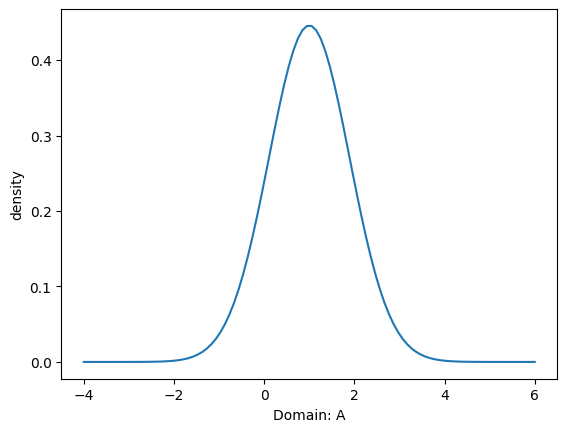

Density at A=0.5 is 0.3815105565219395
Factor over ('A',),
μ = [1.],
Σ = 
[[0.8]]


In [6]:
# Test 1 dimensional factor
a = GaussianFactor(('A',), mu=1, sigma=.8)    # TODO
a.plot()
# Other testing information:
print(f"Density at A=0.5 is {a.density([.5])}")
print(a)

The second is bidimensional with $\b \mu = [1, 2]$ and $\Sigma = [[2, 1],[1, 2]]$. You should see a plot like this:

![2-dimensional Gaussian](https://raw.githubusercontent.com/UNSW-COMP9418/Week08/main/img/2D-Gaussian.png "2D Testing Gaussian")

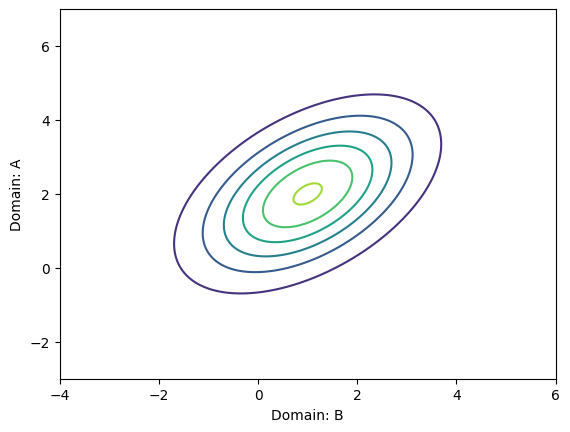

Density at B=0,A=2 is 0.0658407359989627
Factor over ('B', 'A'),
μ = [1. 2.],
Σ = 
[[2. 1.]
 [1. 2.]]


In [7]:
mu = [1, 2]           # TODO
sigma =  [[2,1],[1,2]]        # TODO
b = GaussianFactor(('B', 'A'), mu, sigma)
b.plot()
# Other testing information:
print(f"Density at B=0,A=2 is {b.density([0,2])}")
print(b)

# Gaussian Bayesian Networks

The Gaussian Bayesian Network is a model for continuous variables. The figure below illustrates one of these models for a simple toy example with four variables: Inside temperature ($I$), Outside temperature ($O$), Sensor ($S$), and Energy ($E$). In this model, the sensor measures the internal temperature, and the amount of energy spent to control the temperature is related to the inside and outside temperatures.

![Gaussian Bayes Net](https://raw.githubusercontent.com/UNSW-COMP9418/Week08/main/img/GaussianBayesNet.png "Example Gaussian Bayesian Network")

You have probably noticed that our current Gaussian factors are suitable for representing the unconditional probabilities of variables without parents, such as $I$ and $O$.

However, we will need a different representation for a conditional Gaussian distribution. One representation often used is the linear Gaussian model.

# Linear Gaussian Model

A linear Gaussian model is a simple representation used for conditional Gaussian distributions. In this model:
1. The mean is a linear combination of the parents' values.
2. The variance is a parameter that is independent of the parents.

Although simple, this model is often used in practice. For instance, the sensor ($S$) in the previous figure is modelled by $S \sim  \mathcal{N}(I, \sigma^2_S)$. This means the sensor reads, on average, the same as the inside temperature $I$. This is equivalent to saying that the sensor is not biased (it does not systematically under- or over-estimate the inside temperature). The variance is the sensor error often reported by the manufacturer in its technical documentation.

Similarly, the Energy ($E$) has a model $E \sim \mathcal{N}(\beta_0 + \beta_1 I + \beta_2 O; \sigma^2_E)$. This means that the energy is a quantity that linearly depends on the inside and outside temperatures, as we can expect the amount of energy to be related to the difference between these temperatures. Notice that the $\beta$ parameters can be negative.

## Exercise

Let's make a conditional factor using a linear Gaussian model. We want to define a variable $Y$ as a linear combination of parent Gaussian variables. This means $Y = \beta_0 X_0 + \beta_1 X_1 + ... \beta_n X_n + b$, or equivalently $Y = \beta^T X + b$. Each $X_i$ is a Gaussian variable of unknown mean and variance, and $b$ is a bias random variable with mean $\mu_b$ and variance $\sigma_b^2$.

Then, we can represent this conditional distribution with the following values for $K$, $h$, and $g$:

$$
\begin{align}
K_{Y|X} &= \begin{bmatrix}
\frac{1}{\sigma_b^2} & -\frac{1}{\sigma^2_b}\beta^T\\
-\frac{1}{\sigma^2_b}\beta & \frac{1}{\sigma^2_b}\beta \beta^T\\
\end{bmatrix}
\\
h_{Y|X} &= \begin{bmatrix}
\frac{1}{\sigma^2_b}\mu_b\\
-\frac{1}{\sigma^2_b}\mu_b\beta\\
\end{bmatrix}
\\
g_{Y|X} &= -\frac{1}{2}\left( \frac{\mu_b^2}{\sigma^2_b} \right)- \frac{1}{2}\log(2\pi\sigma_b^2)
\end{align}
$$

Note that $K_{Y|X}$ is a [Block Matrix](https://en.wikipedia.org/wiki/Block_matrix). The submatricies of $K_{Y|X}$ have shapes $\begin{bmatrix}
1\times1 & 1\times n\\
n\times 1 & n\times n\\
\end{bmatrix}$.

Now it is your turn. We will implement the `_init_as_conditional` method, which is called by `__init__` when we want to create a conditional Gaussian factor. We have completed most of the work and left some gaps to be filled in using the equations shown above.

In [9]:
class GaussianFactor(GaussianFactor):
    def _init_as_conditional(self, child, parents, beta, mean, var):
        '''
        This function initialises the factor as a conditional distribution P(Y|X),
        where Y = \beta^T X + b. The __init__ function will be the only function to call it.
        Arguments:
            child:     Name of Y
            parents:   Names of each X
            beta:      vector to multiply with X
            mean:      mean of b
            var:       variance of b
        '''
        n = len(beta)
        beta = np.array(beta).reshape((n,1)) # make sure beta is a column vector
        K = np.zeros((n+1,n+1))

        # top left section of K
        K[0,0] = 1/var # TODO
        # top right section of K
        K[0:1,1:] = -(1/var)*beta.T # TODO
        # bottom left section of K
        K[1:,0:1] = -(1/var)*beta # TODO
        # bottom right section of K
        K[1:,1:] = (1/var)*beta@beta.T # TODO

        h = np.zeros((n+1,1))
        # top section of h
        h[0,:] = mean/var # TODO
        # bottom section of h
        h[1:,:] = -(mean/var) *beta # TODO

        # reshape h to be row vector (for consistency with previous format)
        h = h.reshape(-1)

        g = -(1/2)*(mean**2/var) - (1/2)*np.log(2*np.pi*var)

        return K,h,g

################
# Test code
################

b = GaussianFactor(('B', 'A'), beta=[2], b_mean=1, b_var=0.3**2)
print("K = \n", b.K)
print("h =", b.h)
print("g =", b.g)
print()

e = GaussianFactor(('B', 'A', 'D'), beta=[5,2], b_mean=-1, b_var=0.5**2)
print("K = \n", e.K)
print("h =", e.h)
print("g =", e.g)
print()

K = 
 [[ 11.11111111 -22.22222222]
 [-22.22222222  44.44444444]]
h = [ 11.11111111 -22.22222222]
g = -5.270521284434292

K = 
 [[  4. -20.  -8.]
 [-20. 100.  40.]
 [ -8.  40.  16.]]
h = [-4. 20.  8.]
g = -2.2257913526447273



If your solution is correct, you should see the following output:
```
K =
 [[ 11.11111111 -22.22222222]
 [-22.22222222  44.44444444]]
h = [ 11.11111111 -22.22222222]
g = -5.270521284434292

K =
 [[  4. -20.  -8.]
 [-20. 100.  40.]
 [ -8.  40.  16.]]
h = [-4. 20.  8.]
g = -2.2257913526447273
```

# Joining Gaussian Factors

Our new class can now represent conditional and unconditional Gaussian distributions using the canonical form. It is time to start implementing the three main operations: join, marginalisation, and setting evidence.

We start with join. Before coding this operation, we will need a helper function. In tutorial 2, before we multiplied two arrays, we had to reorder the domain of a factor and extend it to include new variables. We will create a separate function for this purpose, as we need to be able to reorder the domain for the join, marginalize, and evidence functions.

We need a way to do this for Gaussian factors. Fortunately, it's not too complicated. We will implement a method for you called `_extend`. This method receives as an argument the new domain that it needs to have and shuffles up $K$, $h$, and $g$ to match the order of the new domain. If the domain contains new variables not in the current domain, we can put zeros in the corresponding locations of $K$ and $h$.

In [10]:
class GaussianFactor(GaussianFactor):
    def _extend(self, new_domain):
        '''
        This function is for adding variables to the domain or reordering the variables in the domain
        Note that self.domain must contain a subset of the variables in new_domain
        '''
        n = len(new_domain)

        # add zeros to K and h corresponding to the new variables
        new_K = np.zeros((len(new_domain),len(new_domain)))
        new_K[:len(self.domain), :len(self.domain)] = self.K
        new_h = np.zeros(len(new_domain))
        new_h[:len(self.domain)] = self.h
        new_g = self.g
        old_order = list(self.domain) + list(set(new_domain)-set(self.domain))
        # shuffle rows and columns of K according to new order
        new_order = []
        for v in new_domain:
            new_order.append(old_order.index(v))
        new_K = new_K[new_order,:]
        new_K = new_K[:,new_order]

        # shuffle h according to new order
        new_h = new_h[new_order]

        return self.__class__(new_domain, K=new_K, h=new_h, g=new_g)

####################
# Demonstration code
####################

e = GaussianFactor(('B', 'A', 'D'), beta=[5,2], b_mean=-1, b_var=0.5**2)
print("K = \n", e.K)
print("h =", e.h)
print("g =", e.g)
print()

f = e._extend(('D', 'A', 'B', 'E'))
print("K = \n", f.K)
print("h =", f.h)
print("g =", f.g)

K = 
 [[  4. -20.  -8.]
 [-20. 100.  40.]
 [ -8.  40.  16.]]
h = [-4. 20.  8.]
g = -2.2257913526447273

K = 
 [[ 16.  40.  -8.   0.]
 [ 40. 100. -20.   0.]
 [ -8. -20.   4.   0.]
 [  0.   0.   0.   0.]]
h = [ 8. 20. -4.  0.]
g = -2.2257913526447273


## Exercise

Finally, we are ready to implement `join`. The math is really simple. If we have two factors in the canonical form, we can add the internal parameters:

$$\mathcal{C}(K_1,\b h_1,g_1) \times \mathcal{C}(K_2,\b h_2, g_2) = \mathcal{C}(K_1 + K_2, \b h_1 + \b h_2, g_1 + g_2)$$
Notice that before summing $K$ and $\b h$, we need to ensure they have the same dimensions and variabls order. We use the recently coded `_extend` method to ensure that.

Factor over ('A',),
μ = [5.],
Σ = 
[[0.64]]
Factor over ('A', 'B'),
μ = [ 5. 13.],
Σ = 
[[0.64 1.28]
 [1.28 2.65]]


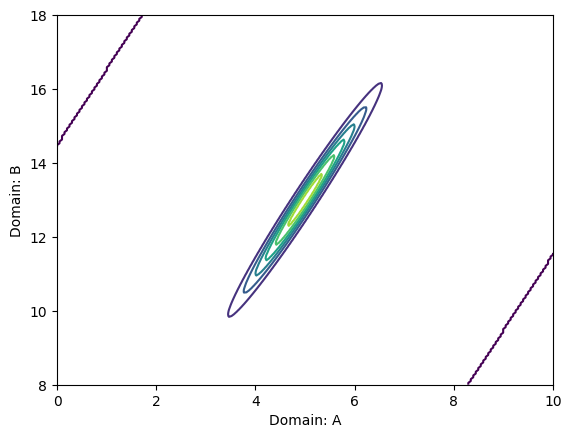

Factor over ('A',),
μ = [1.40449438],
Σ = 
[[0.17977528]]


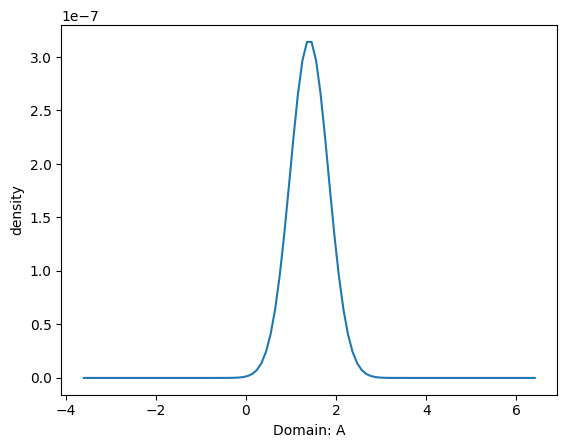

In [11]:
class GaussianFactor(GaussianFactor):
    def join(self, other):
        '''
        This function multiplies two factors.
        '''
        new_domain = list(self.domain) + list(set(other.domain)-set(self.domain))

        # extend the domain of self and other
        new_self = self._extend(new_domain)
        new_other = other._extend(new_domain)

        # Calculate the new values of K, h and g
        K = new_self.K + new_other.K # TODO
        h = new_self.h + new_other.h # TODO
        g = new_self.g + new_other.g # TODO

        # return new joined factor
        return self.__class__(new_domain,K=K,h=h,g=g)

    def __mul__(self, other):
        '''
        Override the * operator, so that it can be used to join factors
        '''
        return self.join(other)

################
# Test code
################

a = GaussianFactor(('A',), mu=5., sigma=0.8**2)
b = GaussianFactor(('B','A'), beta=[2], b_mean=3, b_var=0.3**2)
c = a.join(b)
print(a)
print(c)
c.plot()

d = GaussianFactor(('A',), mu=0, sigma=0.5**2)
e = d*a
print(e)
e.plot()

Output should be:
```
Factor over ('A', 'B'),
μ = [ 5. 13.],
Σ =
[[0.64 1.28]
 [1.28 2.65]]

Factor over ('A',),
μ = [1.40449438],
Σ =
[[0.17977528]]
```

# Marginalising Factors

Now, we will implement the marginalize function. This involves splitting up the domain into:

1. A set of variables to keep, which we will call $x$, and
2. A variable to integrate, which we will call $y$.

The equations to update $K$, $h$ and $g$ are:
$$
\begin{align}
K' &= K_{xx} - K_{xy}K_{yy}^{-1}K_{yx} \\
h' &= h_{x} - K_{xy}K_{yy}^{-1}h_y \\
g' &= g + \frac{1}{2}\left(\log |2\pi K_{yy}^{-1}| + h_y^T K_{yy}^{-1}h_y\right)
\end{align}
$$

## Exercise

Now it is your turn. Complete the code for the method `marginalize` below. We have done most of the work for you.

In [ ]:
class GaussianFactor(GaussianFactor):
    def marginalize(self, var):
        '''
        This function integrates out one variable from the domain
        '''
        n = len(self.domain)
        new_domain = list(self.domain)
        new_domain.remove(var)
        f = self._extend(new_domain+[var]) #reorder the variables to put var last

        # Select submatricies from K and h
        K_yy_inv = np.linalg.inv(f.K[-1:,-1:])
        K_xx = f.K[:-1,:-1]
        K_xy = f.K[:-1,-1:]
        K_yx = f.K[-1:,:-1]
        h_x = f.h[:-1]
        h_y = f.h[-1:]

        # Use the submatricies above to calculate the updated K, h and g
        new_K = K_xx - K_xy@K_yy_inv@K_yx # TODO
        new_h = h_x - K_xy@K_yy_inv@h_y # TODO
        new_g = f.g + (1/2)*(np.log(np.linalg.det(2*np.pi*K_yy_inv))+h_y.T@K_yy_inv@h_y) # TODO np.log 反正学会了np可以调用出来log了

        return self.__class__(new_domain, K=new_K, h=new_h,g=new_g)

################
# Test code
################

a = GaussianFactor(('A', 'B'), mu=[5., 13.], sigma=[[0.64, 1.28],[1.28, 2.65]])
print(a)
b = a.marginalize('A')
print(b)

d = GaussianFactor(('D',), mu=1, sigma=0.2)
e = GaussianFactor(('B', 'A', 'D'), beta=[5,2], b_mean=-1, b_var=0.5**2)
f = e*a*d
print(f)
f = f.marginalize('A').marginalize('D')
print(f)

Output should be:
```
Factor over ('A', 'B'),
μ = [ 5. 13.],
Σ =
[[0.64 1.28]
 [1.28 2.65]]

Factor over ('B',),
μ = [13.],
Σ =
[[2.65]]

Factor over ('B', 'A', 'D'),
μ = [5.93478261 1.3826087  0.24637681],
Σ =
[[ 0.61195652  0.23652174 -0.2173913 ]
 [ 0.23652174  0.10573913 -0.11130435]
 [-0.2173913  -0.11130435  0.17681159]]

Factor over ('B',),
μ = [5.93478261],
Σ =
[[0.61195652]]
```

# Setting evidence

This is our last method implementation for the `GaussanFactor` class: the evidence method.

Similar to `marginalize`, we need to split the domain into parts. The set $x$ will represent the variables we are keeping, and $y$ will represent the variables we are setting to a specific value. The specific values are specified by a vector $\b y$.
Then the equations to update $K$, $h$ and $g$ are:

$$
\begin{align}
K' &= K_{xx} \\
\b h' &= \b h_{x} - K_{xy} \b y \\
g' &= g + h_y^T \b y - \frac{1}{2} \b y^T K_{yy} \b y
\end{align}
$$

## Exercise

Now it is your turn. Do not worry, we have done most of the heavy lifting for you.

Factor over ('A',),
μ = [5.],
Σ = 
[[0.64]]

Factor over ('A', 'B'),
μ = [ 5. 13.],
Σ = 
[[0.64 1.28]
 [1.28 2.65]]


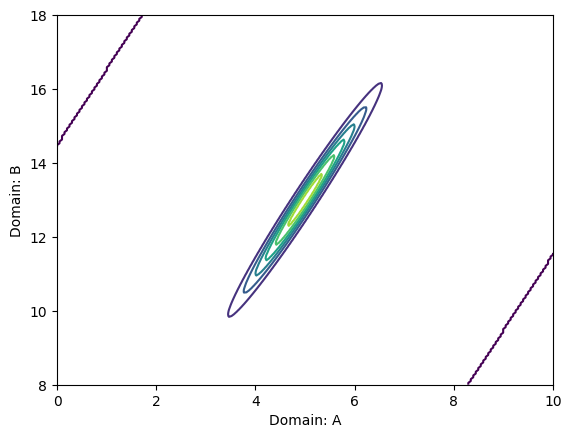

Factor over ('B',),
μ = [9.],
Σ = 
[[0.09]]


In [12]:
class GaussianFactor(GaussianFactor):
    def evidence(self, **kwargs):
        '''
        Sets evidence which results in removal of the evidence variables
        This function must be used to set evidence on all factors before any are joined,
        because it removes the evidence variables from the factor

        Usage: fac.evidence(A=4.6,B=-0.3)
        This returns a factor which has set the variable 'A' to '.6 and 'B' to -0.3.
        '''
        evidence_dict = kwargs

        if(len(evidence_dict) == 0):
            return self

        # work out new domain vars and evidence vars
        new_domain = list(self.domain)
        evidence_vars = []
        evidence_values = []
        for var,value in evidence_dict.items():
            new_domain.remove(var)
            evidence_vars.append(var)
            evidence_values.append(value)

        # rearrange the domain to put evidence vars last
        f = self._extend(new_domain+evidence_vars)

        # Split up K and h into sections
        n = len(evidence_vars)
        m = len(new_domain)
        K_xx = f.K[:m,:m]
        K_xy = f.K[:m,-n:]
        K_yy = f.K[-n:,-n:]
        h_x = f.h[:m]
        h_y = f.h[-n:]
        # put evidence variables into a vector called y
        y = np.array(evidence_values)

        # update variables
        # new_K = ... # TODO
        # new_h = ... # TODO
        # new_g = ... # TODO
        new_K = K_xx
        new_h = h_x - K_xy@y
        new_g = f.g+h_y.T@y - (1/2)*y.T@K_yy@y
        return self.__class__(new_domain, K=new_K, h=new_h,g=new_g)

################
# Test code
################

a = GaussianFactor(('A',), mu=5., sigma=0.8**2)
print(a)
print()
b = GaussianFactor(('B', 'A'), beta=[2], b_mean=3, b_var=0.3**2)
c = a.join(b)
print(c)
c.plot()
print(c.evidence(A=3))

Solution should match:
```
Factor over ('A',),
μ = [5.],
Σ =
[[0.64]]

Factor over ('A', 'B'),
μ = [ 5. 13.],
Σ =
[[0.64 1.28]
 [1.28 2.65]]

Factor over ('B',),
μ = [9.],
Σ =
[[0.09]]
```

# Additional methods

Congratulations! We are done with the `GaussianFactor` class. We add two methods for completeness. `sample` generates one sample from the distribution specified in the Gaussian factor. `normalize` normalizes a factor and it is particularly useful after we set evidence.

Factor over ('A', 'B'),
μ = [1. 3.],
Σ = 
[[0.8  1.6 ]
 [1.6  3.29]]


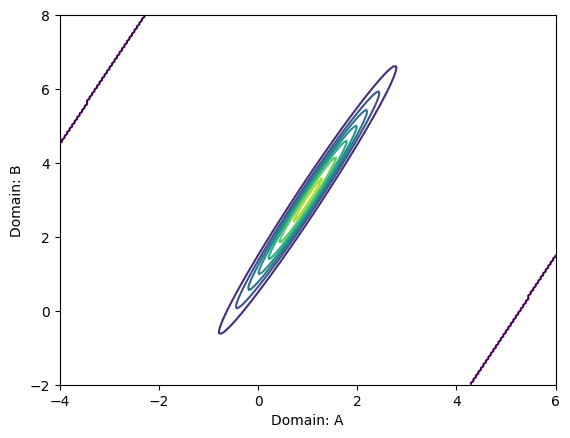

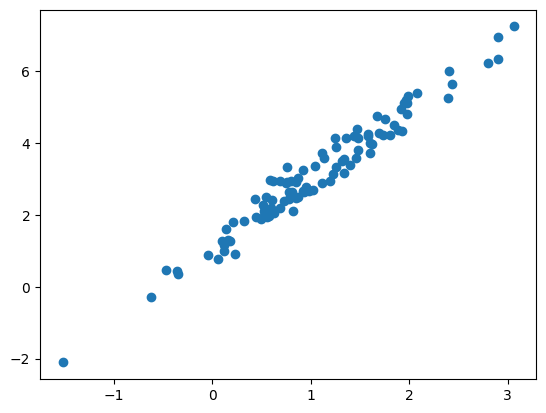

In [13]:
class GaussianFactor(GaussianFactor):
    def sample(self, **kwargs):
        '''
        Draw a sample from this distribution, given evidence.
        output: dict containing a map from variable names to values
        '''
        f = self.evidence(**kwargs)
        sample = np.random.multivariate_normal(f.mean(), f.covariance())
        sample_dict = dict((var, sample[i]) for i,var in enumerate(f.domain))
        return sample_dict

    def normalize(self):
        '''
        Normalize the factor (will only work if the covariance is well-defined)
        '''
        n = len(self.domain)
        self.g = -0.5*self.mean().T@self.h - np.log((2*np.pi)**(n/2)*np.linalg.det(self.covariance())**(1/2))
        return self


#################
# Demonstration
#################

# Compare multivariate sampling and plotting, after
a = GaussianFactor(('A',),mu=1,sigma=0.8)
b = GaussianFactor(('B','A'),beta=[2],b_mean=1,b_var=0.3**2)
c = a.join(b)
print(c)
c.plot()
samples = [c.sample() for i in range(100)]
x = [s['A'] for s in samples]
y = [s['B'] for s in samples]
plt.plot(x,y,'o')
plt.show()

# Question 1 from the theory part

Let's solve Question 1 from the theory part and use it to develop a simple approach to replying to probabilistic queries using the sampling method from the previous cell. The next cell restates the problem description.

You received a job offer and decided to move to Alaska. The only issue is that you have a beloved tropical freshwater fish tank that requires a temperature between 24$^{\circ}$C and 27$^{\circ}$C. Before travelling, you decided to create a temperature control system. You visited a local electronics store to purchase a digital temperature sensor and selected three different models: $S_A$, $S_B$, and $S_C$.

$S_A$ and $S_B$ are more affordable sensors that appear reasonably accurate for the temperature range you are interested in. You read the technical specification and found these plots:

![Temperature sensors](https://raw.githubusercontent.com/UNSW-COMP9418/Week08/main/img/Temperature_sensors.png "Temperature sensors")

$S_C$ is a more expensive sensor, and the manufacturer claims that it is an unbiased sensor, i.e., the sensor measures the actual temperature on average. Additionally, the manufacturers claim that the variance in the sensors' readings for $S_A$ is $.2^{2\circ}$C, $S_B$ is $.3^{2\circ}$C, and $S_C$ is $.5^{2\circ}$C.

You would like to know the probability that the actual temperature is less than 24$^{\circ}$C when the three sensors read this same temperature.

Design a Bayesian Gaussian network for this problem. You reckon that the average indoor temperature at your Alaska home will be $25^\circ$C, but as you have never lived there, you want to assign a large variance of $5^{2\circ}$C.

## Exercise

Let's implement This Gaussian Bayesian network in the next cell and plot the resulting distribution.

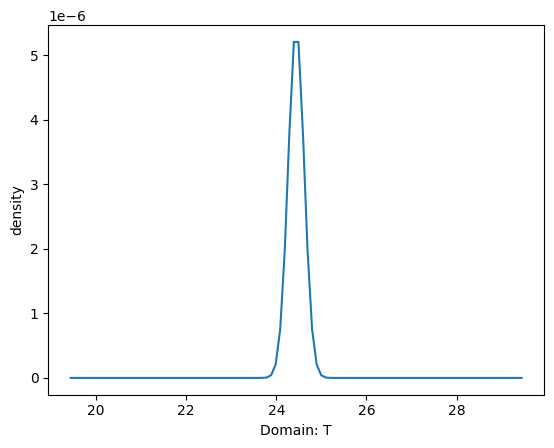

In [14]:
# T = GaussianFactor(...)
# SA = GaussianFactor(...)
# SB = GaussianFactor(...)
# SC = GaussianFactor(..)

# # Join factors and set evidence

# F = ...

# F.plot()
T = GaussianFactor(('T',),mu=25,sigma=5**2)
SA = GaussianFactor(('SA', 'T'),beta=[3/4],b_mean=5,b_var=.2**2)
SB = GaussianFactor(('SB', 'T'),beta=[1.1],b_mean=-2,b_var=.3**2)
SC = GaussianFactor(('SC', 'T'),beta=[1],b_mean=0,b_var=.5**2)

F = T * SA * SB * SC
F = F.evidence(SA=24)
F = F.evidence(SB=24)
F = F.evidence(SC=24)

F.plot()


It appears that the temperature will likely be below the desired minimum. Can you explain why this is the case?

To obtain a numerical response to this question, we can use the ``sample`` method that was implemented earlier. The idea is to use a Monte Carlo approach that generates a large set of data points, computing how many are below $24^\circ$C.

The next cell assumes that the factor ``F`` stores the resulting Gaussian distribution after joining and setting evidence.

In [ ]:
samples = [F.sample() for i in range(10000)]
temperatures = np.array([s['T'] for s in samples])
counts = temperatures < 24
print(f'The probability of having temperature below 24C is {counts.mean()}')

# Monte Carlo approach

Monte Carlo approaches will be further explored in the following lecture. For now, we notice that these approaches are highly flexible and can help us to easily compute probabilities in higher-dimensional distributions.

We conclude with a small challenge. For the previous exercise, how can we use a Monte Carlo simulation to answer the query: What is the probability that the aquarium temperature is above 24°C, given that all three sensors read temperatures above this same temperature?

## Exercise

Let's use the Monte Carlo simulation to answer the query above. It will allow us to not set evidence for a particular sensor reading, but to have a more complex situation where the sensors read above a particular temperature.

You only need to obtain the joint probability distribution and use sampling to compute the probability given the conditions.

In [ ]:
T = GaussianFactor(...)
SA = GaussianFactor(...)
SB = GaussianFactor(...)
SC = GaussianFactor(..)

# Join factors but do not set evidence

F = ...

# Select the samples that the sensors have all reading above 24C

# Compute the fraction of these readings in each the temperature is below 24C

In [15]:
T = GaussianFactor(('T',),mu=25,sigma=5**2)
SA = GaussianFactor(('SA', 'T'),beta=[3/4],b_mean=5,b_var=.2**2)
SB = GaussianFactor(('SB', 'T'),beta=[1.1],b_mean=-2,b_var=.3**2)
SC = GaussianFactor(('SC', 'T'),beta=[1],b_mean=0,b_var=.5**2)

# Join factors but do not set evidence
F = T * SA * SB * SC

samples = [F.sample() for i in range(10000)]
np_samples = np.array([[s['T'], s['SA'], s['SB'], s['SC']] for s in samples])

# Select the samples that the sensors have all reading above 24C
sensors_mask = np_samples[:, 1:] > [24, 24, 24]
sensors_above_temperature = np.all(sensors_mask, axis=1)

# Compute the fraction of these readings in each the temperature is below 24C
counts = np_samples[sensors_above_temperature, 0] < 24

print(f'The probability of having temperature below 24C is {counts.mean()}')

The probability of having temperature below 24C is 0.0


# Conclusion

That is all for today! In the following tutorial, we will explore Monte Carlo simulations in more detail and examine how to approximate probabilistic queries using forward, rejection, likelihood, and Gibbs sampling.